## Get the cleaned dataset and selected features

In [2]:
import os
from pathlib import Path
import pandas as pd

# Load data
path = Path(os.getcwd() + "/..").resolve()
dataset_path = path/'Datasets/Tabular/FOOD-DATA-GROUP.csv'
df = pd.read_csv(dataset_path)

df = df.drop("food", axis=1)
features = df.drop("Caloric Value", axis=1).columns.tolist()
target = "Caloric Value"

# Data transformation
from sklearn.preprocessing import PowerTransformer

# Initialize the PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# Transform the data
df_transformed = pt.fit_transform(df)

# Convert back to DataFrame
df = pd.DataFrame(df_transformed, columns=df.columns)

# Remove outliers
from scipy.stats import zscore
import numpy as np

X = df[features]

# Calculate Z-scores for the features
z_scores = np.abs(zscore(X))

# Define a threshold for Z-scores
threshold = 3

# Find rows where all features have Z-scores greater than the threshold
outliers = (z_scores > threshold).any(axis=1)

# Remove rows where any feature's Z-score exceeds the threshold
X_clean_zscore = X[~outliers]

# Get the indices of the rows that are not outliers
valid_indices = X[~outliers].index

df = df.loc[valid_indices]

# Selected features
df['Protein+Carbohydrates+Fat'] = df['Protein']+df['Carbohydrates']+df['Fat']
df['Total Fats'] = df['Polyunsaturated Fats'] + df['Saturated Fats'] + df['Monounsaturated Fats']

new_features = ['Protein+Carbohydrates+Fat', 'Total Fats']

selected_features = ['Nutrition Density', 'Zinc', 'Vitamin B3', 'Calcium', 'Sodium', 'Dietary Fiber', 'Vitamin C', 'Selenium', 'Protein+Carbohydrates+Fat', 'Total Fats']

X = df[selected_features]
y = df[target]


## Initialise models


GridSearchCV exhaustively considers all parameter combinations. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid (Scikit-learn, 2024).

In [5]:
from sklearn.model_selection import GridSearchCV

### Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg_model = LinearRegression()

### Decision Tree Regressor

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features (Scikit-learn, 2024).

In [9]:
from sklearn.tree import DecisionTreeRegressor

dec_tree_param_grid = [{
    'max_depth': [2, 4, 7, 10],
    'min_samples_split': [2, 4, 7, 10],
    'min_samples_leaf': [2, 4, 7, 10]
    }]
dec_tree_grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), dec_tree_param_grid, cv=5, scoring='r2')
dec_tree_grid_search.fit(X, y)
dec_tree_grid_search.best_estimator_

DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      random_state=42)

Observations:
* max_depth=10: This parameter controls the maximum depth of the tree. A depth of 10 suggests that the model is able to capture enough complexity without being overly simplistic.
* min_samples_split=10: This parameter defines the minimum number of samples required to split an internal node. A value of 10  can help to prevent overfitting by ensuring that splits occur only when there is a sufficient number of data points.
* min_samples_leaf=4: This parameter specifies the minimum number of samples required to be at a leaf node. A value of 4 indicates that the model is less likely to create leaf nodes with very few samples, which can also help in reducing overfitting.


In [11]:
# Initalize DecisionTreeRegressor with hyperparameters based on the best estimator from GridSearchCV
dec_tree_model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=7, random_state=42)

### Random Forest Regressor

A random forest is a meta estimator that fits a number of decision tree regressors on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting (Scikit-learn, 2024).

In [13]:
from sklearn.ensemble import RandomForestRegressor

forest_reg_param_grid = [{
    'n_estimators': [3, 10, 30],
    'min_samples_split': [2, 4, 7, 10],
    'min_samples_leaf': [2, 4, 7, 10]
    }]
forest_reg_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), forest_reg_param_grid, cv=5, scoring='r2')
forest_reg_grid_search.fit(X, y)
forest_reg_grid_search.best_estimator_

RandomForestRegressor(min_samples_leaf=2, n_estimators=30, random_state=42)

Observations:
* n_estimators=30: This parameter specifies the number of trees in the forest. A value of 30 indicates that the model will average the predictions from 30 different decision trees. Generally, a higher number of trees improves model performance by reducing variance, as more trees can lead to more stable and robust predictions.
* min_samples_leaf=2: This parameter sets the minimum number of samples required to be at a leaf node. A value of 2 can help prevent the model from creating overly specific rules (or splits) that may lead to overfitting.



In [15]:
# Initalize RandomForestRegressor with hyperparameters based on the best estimator from GridSearchCV
forest_reg_model = RandomForestRegressor(n_estimators=30, min_samples_leaf=2, min_samples_split=7, random_state=42)

## Calculate R² score for each model for various train-test split

R² score (coefficient of determination) provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance. The best possible score is 1.0 (Scikit-learn, 2024).

In [17]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Test size from 0.1 to 0.9 inclusive
test_sizes = np.arange(0.1, 0.91, 0.01)
test_samples = []
lin_reg_r2_scores = []
dec_tree_r2_scores = []
forest_reg_r2_scores = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    test_samples.append(test_size)

    # Linear Regression
    lin_reg_model.fit(X_train, y_train)
    lin_reg_pred = lin_reg_model.predict(X_test)
    # Calculate R² score and add to list
    lin_reg_r2_scores.append(r2_score(y_test, lin_reg_pred))

    # Decision Tree Regressor
    dec_tree_model.fit(X_train, y_train)
    dec_tree_pred = dec_tree_model.predict(X_test)
    # Calculate R² score and add to list
    dec_tree_r2_scores.append(r2_score(y_test, dec_tree_pred))

    # Random Forest Regressor
    forest_reg_model.fit(X_train, y_train)
    forest_reg_pred = forest_reg_model.predict(X_test)
    # Calculate R² score and add to list
    forest_reg_r2_scores.append(r2_score(y_test, forest_reg_pred))

## Plot R² scores against number of test samples

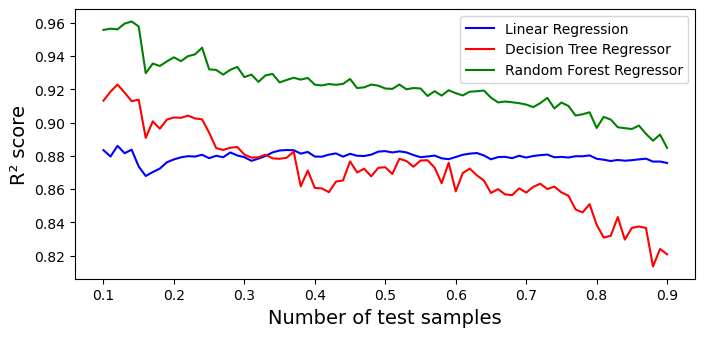

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))

plt.plot(test_samples, lin_reg_r2_scores, "b", label="Linear Regression")
plt.plot(test_samples, dec_tree_r2_scores, "r", label="Decision Tree Regressor")
plt.plot(test_samples, forest_reg_r2_scores, "g", label="Random Forest Regressor")

plt.xlabel("Number of test samples", fontsize=14)
plt.ylabel("R² score", fontsize=14)

plt.legend()

plt.show()

Observations:
* For very small test sizes, the models tend to have higher R² scores, likely because the training set is large and the models can learn better from the data.
* As the test size increases, all models experience a general decrease in their R² scores, which is expected. A larger test size means fewer samples for training, which can lead to models performing less well since they have less data to learn from.
* Linear Regression shows relatively stable performance across test sizes, but its R² score generally decreases as the test size increases.
* Decision Tree Regressor starts with high R² scores, but is prone to overfitting when trained on smaller datasets, which causes it to perform poorly on larger test sizes.
* Random Forest Regressor is more robust than the Decision Tree and provides a good balance between training performance and generalization, especially when test sizes are larger, demonstrating its better ability to handle overfitting and generalize.
* A test size between 0.10 and 0.20 provides high model accuracy for the Random Forest model, balancing a reasonable amount of data in both the training and testing sets.

## Display table with highest and lowest R² score for the models

In [22]:
# Prepare data for table
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
highest_r2_scores = []
highest_r2_test_sizes = []
lowest_r2_scores = []
lowest_r2_test_sizes = []

# For each model, find the highest and lowest R² scores and the corresponding test sizes
for model_r2_scores in [lin_reg_r2_scores, dec_tree_r2_scores, forest_reg_r2_scores]:
    highest_r2 = max(model_r2_scores)
    highest_r2_index = model_r2_scores.index(highest_r2)
    highest_r2_test_size = test_samples[highest_r2_index]

    lowest_r2 = min(model_r2_scores)
    lowest_r2_index = model_r2_scores.index(lowest_r2)
    lowest_r2_test_size = test_samples[lowest_r2_index]

    highest_r2_scores.append(highest_r2)
    highest_r2_test_sizes.append(highest_r2_test_size)
    lowest_r2_scores.append(lowest_r2)
    lowest_r2_test_sizes.append(lowest_r2_test_size)

# Create DataFrame for the results
df_results = pd.DataFrame({
    'Model': models,
    'Highest R² Score': highest_r2_scores,
    'Test size with Highest R² Score': highest_r2_test_sizes,
    'Lowest R² Score': lowest_r2_scores,
    'Test size with Lowest R² Score': lowest_r2_test_sizes
})

df_results['Highest R² Score'] = df_results['Highest R² Score'].map("{:.4f}".format)
df_results['Lowest R² Score'] = df_results['Lowest R² Score'].map("{:.4f}".format)
df_results['Test size with Highest R² Score'] = df_results['Test size with Highest R² Score'].map("{:.2f}".format)
df_results['Test size with Lowest R² Score'] = df_results['Test size with Lowest R² Score'].map("{:.2f}".format)

# Create the header
header = f"| {'Model':<20} | {'Highest R² Score':<18} | {'Test Size with Highest R² Score':<30} | {'Lowest R² Score':<18} | {'Test Size with Lowest R² Score':<30} |"
separator = "-" * len(header)

print(separator)
print(header)
print(separator)

# Print each row of data
for _, row in df_results.iterrows():
    print(f"| {row['Model']:<20} | {row['Highest R² Score']:<18} | {row['Test size with Highest R² Score']:<31} | "
          f"{row['Lowest R² Score']:<18} | {row['Test size with Lowest R² Score']:<30} |")

print(separator)

-------------------------------------------------------------------------------------------------------------------------------------
| Model                | Highest R² Score   | Test Size with Highest R² Score | Lowest R² Score    | Test Size with Lowest R² Score |
-------------------------------------------------------------------------------------------------------------------------------------
| Linear Regression    | 0.8860             | 0.12                            | 0.8679             | 0.16                           |
| Decision Tree        | 0.9229             | 0.12                            | 0.8135             | 0.88                           |
| Random Forest        | 0.9608             | 0.14                            | 0.8848             | 0.90                           |
-------------------------------------------------------------------------------------------------------------------------------------


## References
* Scikit-learn, 2024. LinearRegression. Available at: https://scikit-learn.org/1.5/modules/